# Introduction

In todays coverage meeting Mats mentioned that the bru per cell line coverage seemed much lower than the total RNA coverge reported in ENCODE 3.

Partially that's due to ENCODE 3 reporting a general summary metric for many cell lines and tissues, and partially there might be depth dependencies to coverage. (One would expect it increases to a some saturation point)

That led me to remember the ENCODE 3 RNA evaluation experiments which were unusually deeply sequenced experiments.



In [1]:
import pandas
from pathlib import Path
from tqdm import tqdm
from encoded_client.encoded import ENCODED
import shutil
import pyBigWig
from subprocess import check_call
import pysam
from matplotlib import pyplot
from io import StringIO

In [2]:
server = ENCODED("www.encodeproject.org")

In [3]:
experiment_accessions = [
    'ENCSR000AEC',
    'ENCSR000AED',
    'ENCSR000AEE',
    'ENCSR000AEF',
    'ENCSR000AEG',
    'ENCSR000AEH',
    'ENCSR000AEM',
    'ENCSR000AEN',
    'ENCSR000AEO',
    'ENCSR000AEP',
    'ENCSR000AEQ'
]


In [4]:
table = []

for accession in tqdm(experiment_accessions):
    experiment = server.get_json(accession)
    row = {
        "@id": experiment["@id"],
        "assay_term_name": experiment["assay_term_name"], 
        "biosample_term_name": experiment["biosample_ontology"]["term_name"], 
        "lab": experiment["lab"]["@id"]
    }
    
    default_analysis = experiment["default_analysis"]
    for f in experiment["files"]:
        if f["output_type"] == "alignments" and default_analysis in [x["@id"] for x in f["analyses"]]:
            rep = f["technical_replicates"][0]
            mapped = 0
            for metric in f["quality_metrics"]:
                if "StarQualityMetric" in metric["@type"]:
                    mapped = metric["read_depth"]         
                    
            row = {
                "experiment": experiment["accession"],
                "assay_term_name": experiment["assay_term_name"], 
                "biosample_term_name": experiment["biosample_ontology"]["term_name"], 
                "lab": experiment["lab"]["@id"],
                "replicate": rep,
                "file": f["accession"],
                "href": f["href"],
                "read_depth": mapped,
            }                                
            table.append(row)

table = pandas.DataFrame(table)
table

100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


,experiment,assay_term_name,biosample_term_name,lab,replicate,file,href,read_depth
0,ENCSR000AEC,RNA-seq,GM12878,/labs/thomas-gingeras/,2_1,ENCFF314XXI,/files/ENCFF314XXI/@@download/ENCFF314XXI.bam,91432033
1,ENCSR000AEC,RNA-seq,GM12878,/labs/thomas-gingeras/,1_1,ENCFF563OCX,/files/ENCFF563OCX/@@download/ENCFF563OCX.bam,103904942
2,ENCSR000AED,polyA plus RNA-seq,GM12878,/labs/thomas-gingeras/,1_1,ENCFF729OOW,/files/ENCFF729OOW/@@download/ENCFF729OOW.bam,95478749
3,ENCSR000AED,polyA plus RNA-seq,GM12878,/labs/thomas-gingeras/,2_1,ENCFF550SET,/files/ENCFF550SET/@@download/ENCFF550SET.bam,91840227
4,ENCSR000AEE,RNA-seq,GM12878,/labs/brenton-graveley/,2_1,ENCFF573HFZ,/files/ENCFF573HFZ/@@download/ENCFF573HFZ.bam,72393688
5,ENCSR000AEE,RNA-seq,GM12878,/labs/brenton-graveley/,1_1,ENCFF381QCU,/files/ENCFF381QCU/@@download/ENCFF381QCU.bam,64933964
6,ENCSR000AEF,polyA plus RNA-seq,GM12878,/labs/brenton-graveley/,1_1,ENCFF949BCP,/files/ENCFF949BCP/@@download/ENCFF949BCP.bam,43099127
7,ENCSR000AEF,polyA plus RNA-seq,GM12878,/labs/brenton-graveley/,2_1,ENCFF544CGO,/files/ENCFF544CGO/@@download/ENCFF544CGO.bam,124749627
8,ENCSR000AEG,polyA plus RNA-seq,GM12878,/labs/barbara-wold/,1_1,ENCFF140UJC,/files/ENCFF140UJC/@@download/ENCFF140UJC.bam,85043918
9,ENCSR000AEG,polyA plus RNA-seq,GM12878,/labs/barbara-wold/,2_1,ENCFF385DEF,/files/ENCFF385DEF/@@download/ENCFF385DEF.bam,85952585


In [5]:
!dpkg --status picard-tools | grep Version

Version: 2.24.1+dfsg-1


In [6]:

star_container = str(Path("~diane/public_html/containers/star-bash-2.7.10a.sif"))
ucsc_tools = str(Path("~diane/public_html/containers/ucsc-tools-433.sif"))


In [7]:
def build_chrom_info(analysis_dir, bamfile):
    target = analysis_dir / (bamfile.stem + ".chrominfo")
    with pysam.AlignmentFile(bamfile, 'rb') as alignment, open(target, 'wt') as chrom_info:
        for row in alignment.header['SQ']:
            name = row['SN']
            length = row['LN']
            chrom_info.write(name)
            chrom_info.write('\t')
            chrom_info.write(str(length))
            chrom_info.write("\n")
    return target

def build_bigwig(bamfile):
    analysis_dir = bamfile.parent
    bedgraph = analysis_dir/(bamfile.stem + "_all.bg")
    bigwig = analysis_dir/(bamfile.stem + "_all.bw")
    
    if bigwig.exists():
        print("{} exists".format(bigwig))
        return
    
    !singularity run $star_container --runMode inputAlignmentsFromBAM \
      --inputBAMfile $bamfile \
      --outWigType bedGraph \
      --outWigReferencesPrefix chr \
      --outWigStrand Unstranded \
      --outWigNorm None \
      --outFileNamePrefix $analysis_dir/
    
    # the two files are the same since there's only unique reads in the alignment.
    (analysis_dir/"Signal.Unique.str1.out.bg").rename(bedgraph)
    (analysis_dir/"Signal.UniqueMultiple.str1.out.bg").unlink()
    
    !singularity exec $ucsc_tools bedSort $bedgraph $bedgraph
    
    chrominfo = build_chrom_info(analysis_dir, bamfile)
    !singularity exec $ucsc_tools bedGraphToBigWig $bedgraph $chrominfo $bigwig
    
    chrominfo.unlink()
    bedgraph.unlink()
    return bigwig
    
def download_bam(server, href):
    p = Path(href)
    target_dir = Path(p.stem)
    target_dir.mkdir(exist_ok=True)
    target = target_dir / p.name
    if not target.exists():
        resp = server.get_response(href, stream=True)
        with open(target, "wb") as outstream:
            shutil.copyfileobj(resp.raw, outstream)
    return target


def compute_coverage(bigwig):
    total_bases = 0
    covered_bases = 0
    
    bw = pyBigWig.open(str(bigwig))
    chromosomes = bw.chroms()
    for chromosome in chromosomes:
        if not (("random" in chromosome) or (chromosome.startswith("chrUn")) or chromosome in ("chrEBV", "chrM")):
            coverage = bw.stats(chromosome, type="coverage")[0]
            total_bases += chromosomes[chromosome]
            covered_bases += (chromosomes[chromosome] * coverage)
    return covered_bases, total_bases


def cache_coverage(downsampled_coverage, downsampled_bigwig):
    if downsampled_coverage.exists():
        with open(downsampled_coverage, "rt") as instream:
            for line in instream:
                covered_bases, total_bases = line.strip().split()
    else:
        covered_bases, total_bases = compute_coverage(downsampled_bigwig)
        with open(downsampled_coverage, "wt") as outstream:
            outstream.write("{}\t{}\n".format(covered_bases, total_bases))

    return float(covered_bases), int(total_bases)

In [8]:
coverage = {}

for i, row in tqdm(table.iterrows(), total=table.shape[0], position=0):
    replicate = row["replicate"]
    href = row["href"]
    read_depth = row["read_depth"]

    full_bam = download_bam(server, href)

    for depth in tqdm([5, 10, 25, 50, 75], position=2):
        if depth < read_depth / 1e6:                
            downsampled_bam = full_bam.parent / "{}_{}m.bam".format(full_bam.stem, depth)
            downsampled_bigwig = full_bam.parent / "{}_{}m_all.bw".format(full_bam.stem, depth)
            downsampled_coverage = full_bam.parent / "{}_{}m_coverage.tsv".format(full_bam.stem, depth)
            
            if not downsampled_bam.exists():
                p = (depth * 1e6) / read_depth
                check_call(["PicardCommandLine", "DownsampleSam", f"I={full_bam}", f"O={downsampled_bam}", f"P={p}"])
                #PicardCommandLine DownsampleSam I=$full_bam O=$downsampled_bam P=$p 2>&1 > /dev/null

            if not downsampled_bigwig.exists():
                downsampled_bigwig = build_bigwig(downsampled_bam)

            covered_bases, total_bases = cache_coverage(downsampled_coverage, downsampled_bigwig)
            coverage[(full_bam.stem, depth)] = {
                "covered_bases": covered_bases,
                "total_bases": total_bases,
                "fraction": covered_bases / total_bases
            }


    full_bigwig = full_bam.parent / "{}_100%_all.bw".format(full_bam.stem)
    if not full_bigwig.exists():
        full_bigwig = build_bigwig(full_bam)                
    full_coverage = full_bam.parent / "{}_100%_coverage.tsv".format(full_bam.stem)
    covered_bases, total_bases = cache_coverage(full_coverage, full_bigwig)
    coverage[(full_bam.stem, "100%")] = {
        "covered_bases": covered_bases,
        "total_bases": total_bases,
        "fraction": covered_bases / total_bases
    }


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 667.97it/s]


100%|██████████| 5/5 [00:00<00:00, 539.56it/s]


100%|██████████| 5/5 [00:00<00:00, 572.13it/s]


100%|██████████| 5/5 [00:00<00:00, 503.98it/s]


100%|██████████| 5/5 [00:00<00:00, 597.09it/s]


100%|██████████| 5/5 [00:00<00:00, 638.52it/s]


 32%|███▏      | 7/22 [00:00<00:00, 64.26it/s]

100%|██████████| 5/5 [00:00<00:00, 470.13it/s]


100%|██████████| 5/5 [00:00<00:00, 489.73it/s]


100%|██████████| 5/5 [00:00<00:00, 509.93it/s]


100%|██████████| 5/5 [00:00<00:00, 502.18it/s]


100%|██████████| 5/5 [00:00<00:00, 482.79it/s]


100%|██████████| 5/5 [00:00<00:00, 563.55it/s]




ENCFF314XXI/ENCFF314XXI_all.bw exists
ENCFF563OCX/ENCFF563OCX_all.bw exists
ENCFF729OOW/ENCFF729OOW_all.bw exists
ENCFF550SET/ENCFF550SET_all.bw exists
ENCFF573HFZ/ENCFF573HFZ_all.bw exists
ENCFF381QCU/ENCFF381QCU_all.bw exists
ENCFF949BCP/ENCFF949BCP_all.bw exists
ENCFF544CGO/ENCFF544CGO_all.bw exists
ENCFF140UJC/ENCFF140UJC_all.bw exists
ENCFF385DEF/ENCFF385DEF_all.bw exists
ENCFF597ZXX/ENCFF597ZXX_all.bw exists
ENCFF150MRJ/ENCFF150MRJ_all.bw exists
ENCFF525NYR/ENCFF525NYR_all.bw exists


 64%|██████▎   | 14/22 [00:00<00:00, 60.56it/s]

100%|██████████| 5/5 [00:00<00:00, 666.65it/s]


100%|██████████| 5/5 [00:00<00:00, 744.46it/s]


100%|██████████| 5/5 [00:00<00:00, 897.41it/s]


100%|██████████| 5/5 [00:00<00:00, 740.57it/s]


100%|██████████| 5/5 [00:00<00:00, 563.07it/s]


100%|██████████| 5/5 [00:00<00:00, 575.16it/s]


 95%|█████████▌| 21/22 [00:00<00:00, 64.01it/s]

100%|██████████| 22/22 [00:00<00:00, 63.30it/s]

ENCFF754JEN/ENCFF754JEN_all.bw exists
ENCFF704RNX/ENCFF704RNX_all.bw exists
ENCFF219JME/ENCFF219JME_all.bw exists
ENCFF864OUS/ENCFF864OUS_all.bw exists
ENCFF696CSX/ENCFF696CSX_all.bw exists
ENCFF108FRI/ENCFF108FRI_all.bw exists
ENCFF578UUD/ENCFF578UUD_all.bw exists
ENCFF688VJF/ENCFF688VJF_all.bw exists
ENCFF156LAV/ENCFF156LAV_all.bw exists


In [9]:
downsampled_coverage

PosixPath('ENCFF156LAV/ENCFF156LAV_75m_coverage.tsv')

In [10]:
df = pandas.DataFrame(coverage)

In [11]:
fractions = df.T["fraction"].unstack()

<AxesSubplot:>

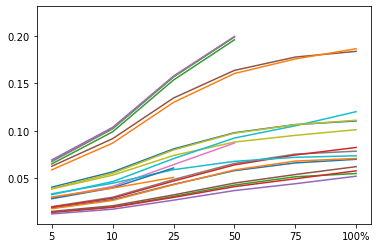

In [12]:
fractions.T.plot(legend=False)

In [13]:
merged = table.merge(fractions, left_on="file", right_index=True)
merged.head()

,experiment,assay_term_name,biosample_term_name,lab,replicate,file,href,read_depth,5,10,25,50,75,100%
0,ENCSR000AEC,RNA-seq,GM12878,/labs/thomas-gingeras/,2_1,ENCFF314XXI,/files/ENCFF314XXI/@@download/ENCFF314XXI.bam,91432033,0.062872,0.091942,0.134726,0.163802,0.177831,0.183848
1,ENCSR000AEC,RNA-seq,GM12878,/labs/thomas-gingeras/,1_1,ENCFF563OCX,/files/ENCFF563OCX/@@download/ENCFF563OCX.bam,103904942,0.059110,0.087238,0.130104,0.160497,0.175820,0.186601
2,ENCSR000AED,polyA plus RNA-seq,GM12878,/labs/thomas-gingeras/,1_1,ENCFF729OOW,/files/ENCFF729OOW/@@download/ENCFF729OOW.bam,95478749,0.039407,0.055459,0.080027,0.097709,0.106600,0.111320
3,ENCSR000AED,polyA plus RNA-seq,GM12878,/labs/thomas-gingeras/,2_1,ENCFF550SET,/files/ENCFF550SET/@@download/ENCFF550SET.bam,91840227,0.040832,0.056960,0.081113,0.098188,0.106741,0.110565
4,ENCSR000AEE,RNA-seq,GM12878,/labs/brenton-graveley/,2_1,ENCFF573HFZ,/files/ENCFF573HFZ/@@download/ENCFF573HFZ.bam,72393688,0.065353,0.099155,0.153645,0.195970,NaN,0.217429


In [14]:
depths = [5,10, 25, 50, 75]
labs = ["/labs/thomas-gingeras/", "/labs/barbara-wold/", "/labs/brenton-graveley/"]

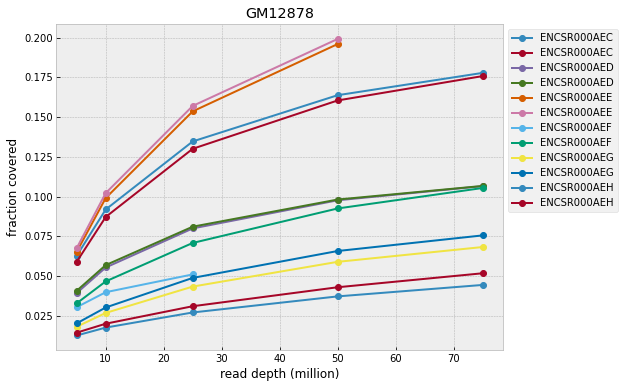

In [15]:
with pyplot.style.context("bmh"):
    f = pyplot.figure(figsize=(8,6))
    ax = f.add_subplot(1,1,1)
    ax.set_xlabel("read depth (million)")
    ax.set_ylabel("fraction covered")
    ax.set_title("GM12878")
    merged[merged["biosample_term_name"] == "GM12878"].set_index("experiment")[depths].T.plot(ax=ax, marker='o')
    _ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")

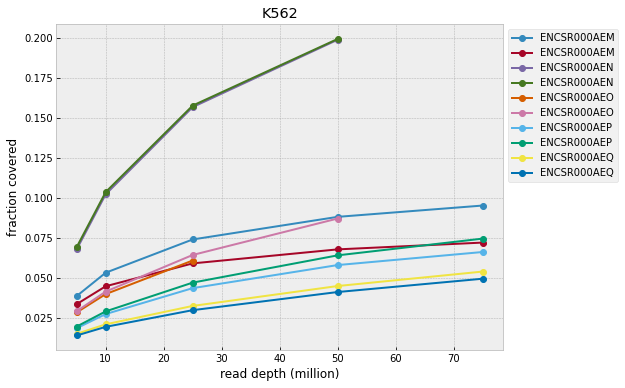

In [16]:
with pyplot.style.context("bmh"):
    f = pyplot.figure(figsize=(8,6))
    ax = f.add_subplot(1,1,1)
    ax.set_xlabel("read depth (million)")
    ax.set_ylabel("fraction covered")
    ax.set_title("K562")
    merged[merged["biosample_term_name"] == "K562"].set_index("experiment")[depths].T.plot(ax=ax, marker="o")
    _ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")

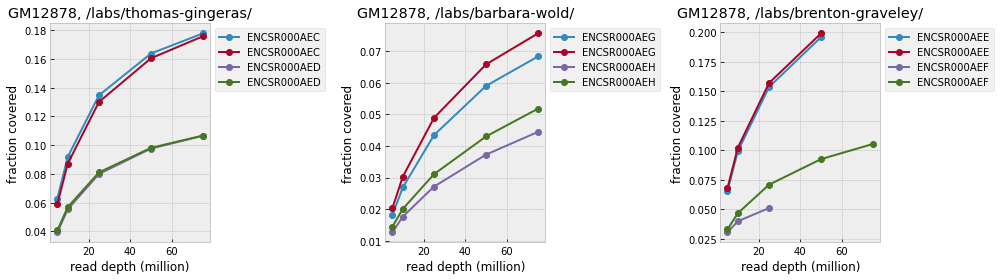

In [31]:
with pyplot.style.context("bmh"):
    f = pyplot.figure(figsize=(14,4))
    for i, lab in enumerate(labs):
        ax = f.add_subplot(1,3,i+1)
        ax.set_xlabel("read depth (million)")
        ax.set_ylabel("fraction covered")
        ax.set_title("GM12878, {}".format(lab))
        merged[(merged["biosample_term_name"] == "GM12878") & (merged["lab"] == lab)].set_index("experiment")[depths].T.plot(ax=ax, marker="o")
        _ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
    f.tight_layout()

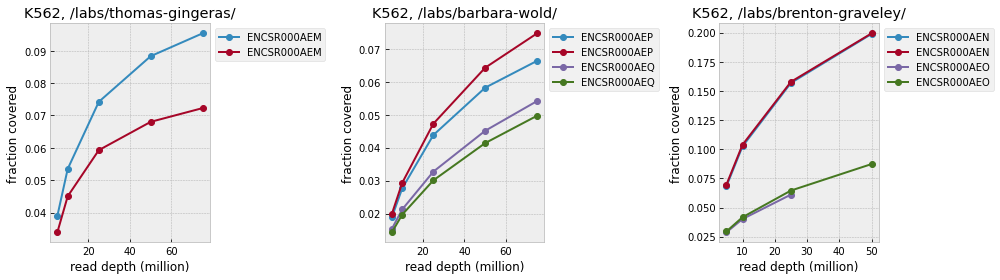

In [26]:
with pyplot.style.context("bmh"):
    f = pyplot.figure(figsize=(14,4))
    ax=None
    for i, lab in enumerate(labs):
        ax = f.add_subplot(1,3,i+1)
        ax.set_xlabel("read depth (million)")
        ax.set_ylabel("fraction covered")
        ax.set_title("K562, {}".format(lab))
        merged[(merged["biosample_term_name"] == "K562") & (merged["lab"] == lab)].set_index("experiment")[depths].T.plot(ax=ax, marker="o")
        _ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
    f.tight_layout()

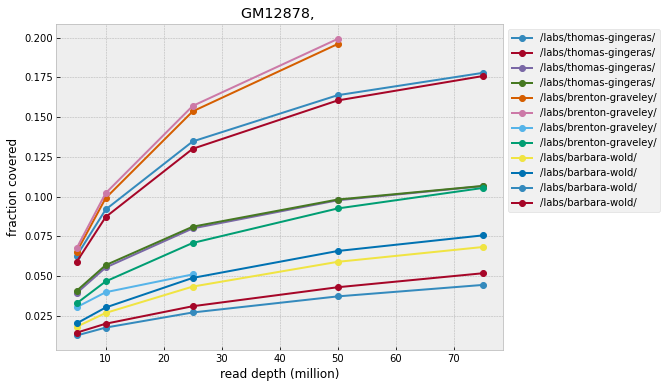

In [32]:
with pyplot.style.context("bmh"):
    f = pyplot.figure(figsize=(8,6))
    ax = f.add_subplot(1,1,1)
    ax.set_xlabel("read depth (million)")
    ax.set_ylabel("fraction covered")
    ax.set_title("GM12878, ")
    merged[merged["biosample_term_name"] == "GM12878"].set_index("lab")[depths].T.plot(ax=ax, marker="o")
    _ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")